In [1]:
import pandas as pd
import pathlib
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report
from sklearn.preprocessing import normalize
from sklearn import svm
from collections import defaultdict
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
lfc_mb_filt=pd.read_csv('../data/standardized_data/cleaned_ML/lfc_mb_filt.csv')
lfc_bin_mb_filt=pd.read_csv('../data/standardized_data/cleaned_ML/lfc_bin_mb_filt.csv')

In [3]:
value_cols = [col for col in lfc_mb_filt.columns if col not in ['Rv_ID', 'Functional_Category']]
value_cols_lfc_bin = [col for col in lfc_bin_mb_filt.columns if col not in ['Rv_ID', 'Functional_Category']]

In [4]:
def rf_lr(mat, cols, C_lr):
    X=mat[cols].values
    y=mat['Functional_Category'].values
    n_classes=mat['Functional_Category'].nunique()
    preds_lr=np.zeros((len(y), n_classes))
    preds_rf=np.zeros((len(y), n_classes))
    #print(X,y)
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train, y_train=SMOTE().fit_resample(X_train, y_train)
        lr=LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=C_lr, random_state=42)
        rf=RandomForestClassifier(n_estimators=100)
        lr.fit(X_train,y_train)
        rf.fit(X_train, y_train)
        preds_lr[test_index,:]=lr.predict_proba(X_test)
        preds_rf[test_index,:]=rf.predict_proba(X_test)
    preds_rf_lr=np.concatenate((preds_lr,preds_rf), axis=1)
    print (preds_rf_lr.shape)
    return preds_rf_lr, y

In [5]:
def ensemble_lr(X, y, C, name):
    n_classes=len(np.unique(y))
    confusion=np.zeros((n_classes, n_classes))
    skf=StratifiedKFold(n_splits=2, shuffle=True)
    train_index, test_index=list(skf.split(X,y))[0]
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train, y_train=SMOTE().fit_resample(X_train, y_train)
    lr=LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=C)
    lr.fit(X_train,y_train)
    y_hat=lr.predict(X_test)
    confusion+=confusion_matrix(y_test, y_hat)
    print (classification_report(y_test, y_hat))
    confusion=normalize(confusion, axis=1, norm='l1')
    accuracy=accuracy_score(y_test, y_hat)
    print (accuracy)
    col_names=['PE/PPE', 'cell wall and\ncell processes', 'information pathways', 'insertion seqs\nand phages', 'intermediary metabolism\nand respiration', 'lipid metabolism', 'regulatory proteins', 'virulence, detoxification,\nadaptation']
    confusion=confusion=pd.DataFrame(confusion, columns=col_names, index=col_names)
    #confusion=pd.DataFrame(confusion, columns=clf.classes_, index=clf.classes_)
    plt.figure(figsize=(7,7))
    rc={'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.labelsize': 14}
    sns.set(rc=rc)
    heat=sns.heatmap(confusion, annot=True, linewidths=.1, fmt='1.2f', square=True)
    heat.set(xlabel='PREDICTED CLASS', ylabel='TRUE CLASS', title=name)
    fig = heat.get_figure()
    fig.savefig('ensemble_preds.png', dpi=500, bbox_inches = "tight")
    return None
    
    
    

In [6]:
X_ensemble,y_ensemble=rf_lr(lfc_bin_mb_filt, value_cols_lfc_bin, C_lr=10)

(2937, 16)


                                         precision    recall  f1-score   support

                                 PE/PPE       0.18      0.56      0.28        81
           cell wall and cell processes       0.36      0.14      0.20       386
                   information pathways       0.25      0.37      0.30       121
              insertion seqs and phages       0.24      0.59      0.34        71
intermediary metabolism and respiration       0.49      0.10      0.17       466
                       lipid metabolism       0.12      0.20      0.15       135
                    regulatory proteins       0.08      0.14      0.10        99
  virulence, detoxification, adaptation       0.12      0.25      0.16       110

                               accuracy                           0.20      1469
                              macro avg       0.23      0.29      0.21      1469
                           weighted avg       0.32      0.20      0.19      1469

0.2042205582028591


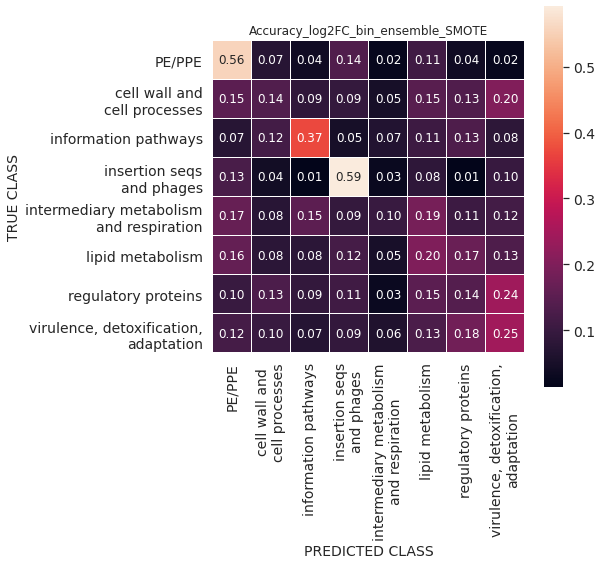

In [7]:
ensemble_lr(X_ensemble, y_ensemble, C=10, name='Accuracy_log2FC_bin_ensemble_SMOTE')

                                         precision    recall  f1-score   support

                                 PE/PPE       0.21      0.57      0.31        81
           cell wall and cell processes       0.37      0.16      0.22       386
                   information pathways       0.24      0.45      0.31       121
              insertion seqs and phages       0.24      0.48      0.32        71
intermediary metabolism and respiration       0.40      0.14      0.20       466
                       lipid metabolism       0.16      0.21      0.19       135
                    regulatory proteins       0.11      0.15      0.13        99
  virulence, detoxification, adaptation       0.08      0.18      0.11       110

                               accuracy                           0.22      1469
                              macro avg       0.23      0.29      0.22      1469
                           weighted avg       0.30      0.22      0.22      1469

0.2198774676650783


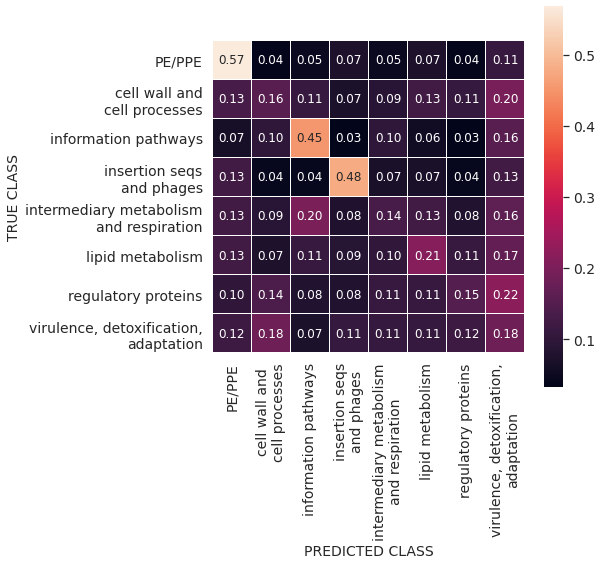

In [8]:
#without title
ensemble_lr(X_ensemble, y_ensemble, C=10, name='')